In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import models, layers
from tensorflow_datasets import datasets

In [3]:
IMAGE_SIZE= 256
BATCH_SIZE= 32
CHANNELS= 3

In [4]:
#build data pipeline

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantVillage",# from the main directory
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [5]:
class_names= dataset.class_names

In [6]:
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [7]:
len(dataset)

141

In [8]:
141*32

4512

(32, 256, 256, 3)
[0 1 2 0 1 1 0 0 1 1 1 1 1 0 0 1 2 2 0 1 0 0 0 0 1 0 1 2 1 0 0 2]


2024-07-17 19:59:12.150925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


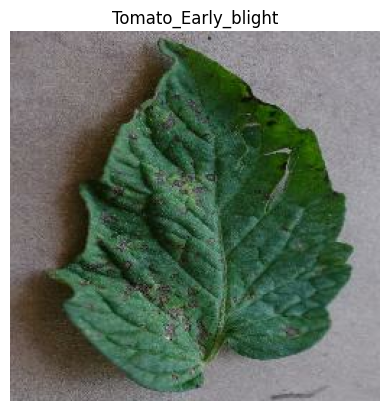

In [9]:
for image_batch, label_batch in dataset.take(1):
    #visualize the images
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])
    plt.axis('off')

    print(image_batch.shape)
    print(label_batch.numpy())

2024-07-17 19:59:12.447297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


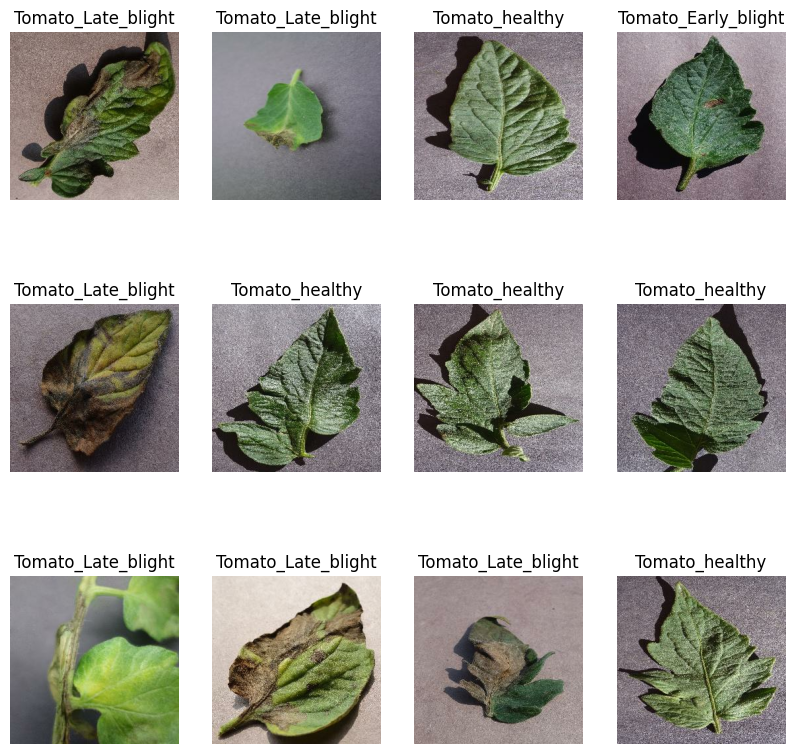

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    #visualize the images
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')


In [11]:
#split the dataset into train and test
# 80% will use as the training , 20% for testing and in this testing dataset we will again classify into validation (10%), and remaining testing
train_size= 0.8
len(dataset)*train_size


112.80000000000001

In [12]:
train_ds= dataset.take(112)
len(train_ds)

112

In [13]:
test_ds= dataset.skip(112)
len(test_ds)

29

In [14]:
val_size= 0.1
len(dataset)*val_size

14.100000000000001

In [15]:
val_ds= test_ds.take(14)
len(val_ds)

14

In [16]:
test_ds=test_ds.skip(14)
len(test_ds)

15

In [17]:
def get_dataset_partitions_tf(ds,train_split= 0.8, val_split= 0.1, test_split=0.1, shuffle=True, shuffle_size= 10000):
    ds_size= len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)
    train_ds= ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds


In [18]:
train_ds, test_ds, val_ds= get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

112

In [20]:
len(test_ds)

15

In [21]:
len(val_ds)

14

In [22]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
#scalling the image
resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [31]:
#data augmentation 
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [32]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
cnn= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')



])
cnn.build(input_shape= input_shape)

/Users/shashi/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
cnn.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy']
)

In [35]:
history= cnn.fit(train_ds, 
                 epochs=50,
                 batch_size=32, 
                 verbose=1,
                 validation_data=val_ds)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 58s 499ms/step - accuracy: 0.5868 - loss: 0.8803 - val_accuracy: 0.7522 - val_loss: 0.6790
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 62s 555ms/step - accuracy: 0.7817 - loss: 0.5012 - val_accuracy: 0.8147 - val_loss: 0.4263
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 61s 548ms/step - accuracy: 0.8344 - loss: 0.3854 - val_accuracy: 0.8482 - val_loss: 0.3977
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 62s 553ms/step - accuracy: 0.8319 - loss: 0.3996 - val_accuracy: 0.8348 - val_loss: 0.4847
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 64s 574ms/step - accuracy: 0.8547 - loss: 0.3429 - val_accuracy: 0.7254 - val_loss: 0.7877
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 69s 616ms/step - accuracy: 0.8698 - loss: 0.3255 - val_accuracy: 0.8638 - val_loss: 0.3974
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 68s 608ms/step - accuracy: 0.8880 - loss: 0.2795 - val_accuracy: 0.8728 - val_loss: 0.3925
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 69s 619ms/step - accuracy: 0.9002 - loss: 0

In [36]:
score= cnn.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9781 - loss: 0.0706


In [37]:
score

[0.09778585284948349, 0.9750000238418579]

In [38]:
history.params
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [39]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss=['val_loss']

2024-07-17 21:05:08.518793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


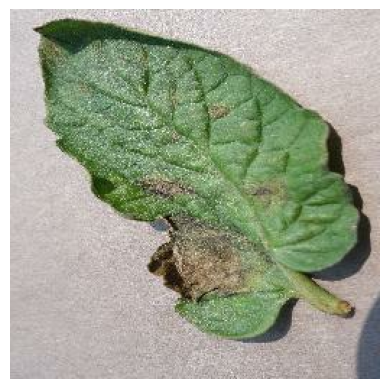

In [42]:
for image_batch, label_batch in test_ds.take(1):
    
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.axis('off')

First image to predict
first image's actual label: Tomato_Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
predicted label: Tomato_Late_blight


2024-07-17 21:05:25.442967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


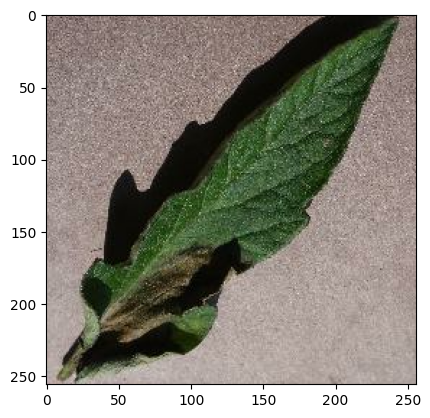

In [45]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image=images_batch[0].numpy().astype('uint8')
    fist_label= labels_batch[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)
    print("first image's actual label:",class_names[fist_label])

    batch_prediction= cnn.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(cnn, img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array= tf.expand_dims(img_array, 0)

    predictions= cnn.predict(img_array)
    predicted_class= class_names[np.argmax(predictions[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2024-07-17 21:05:50.632542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


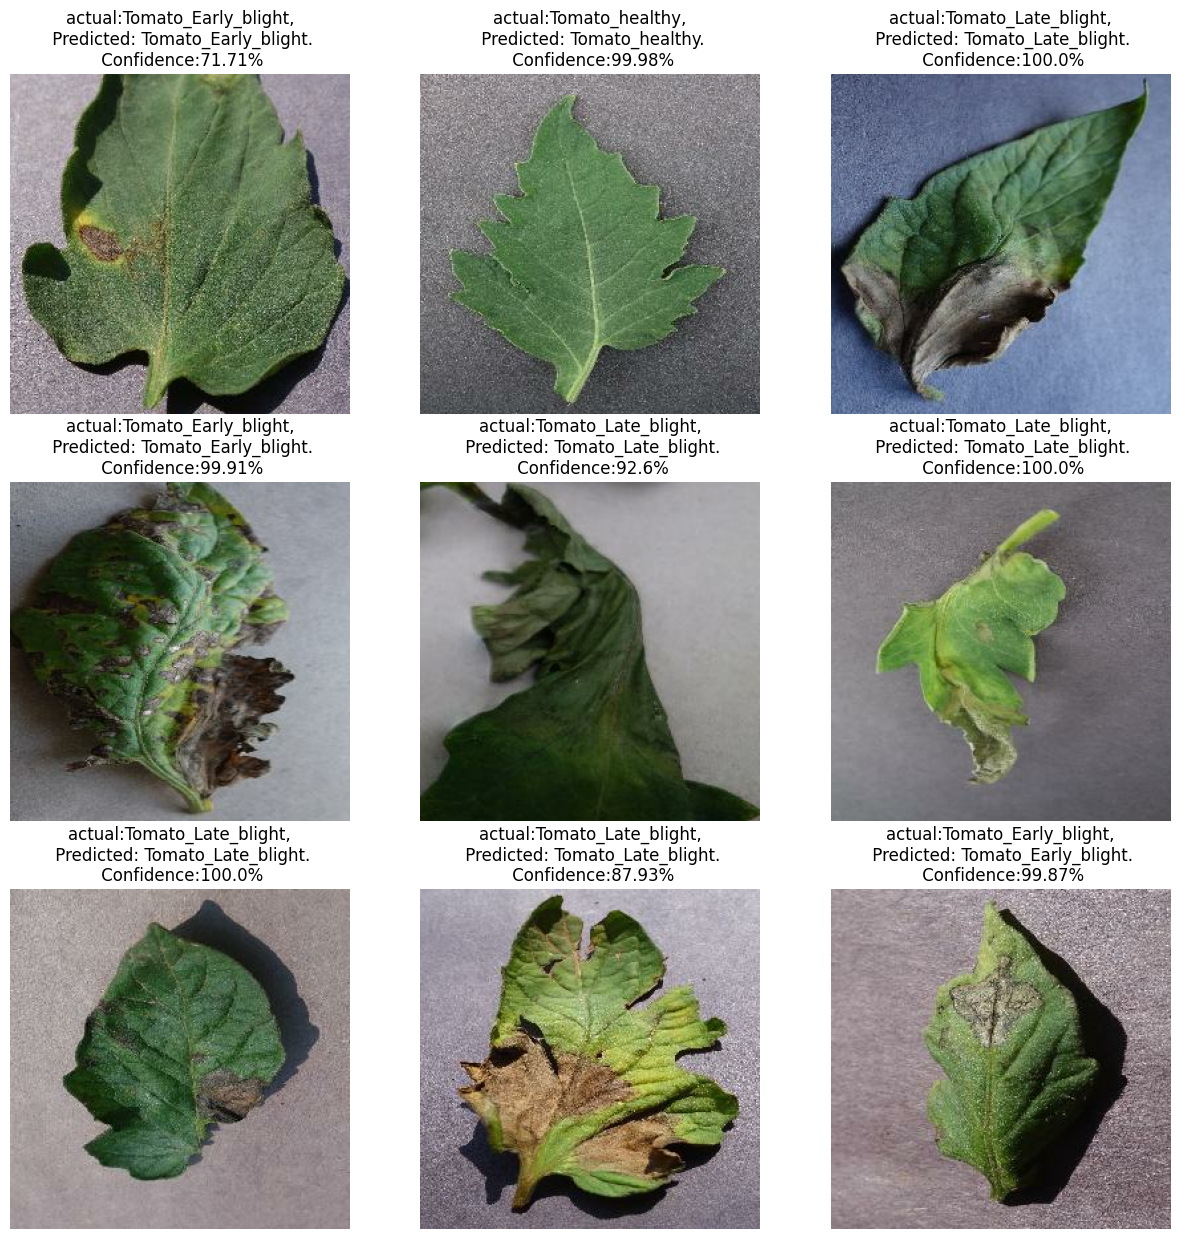

In [49]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence= predict (cnn, images[i].numpy())
        actual_class= class_names[labels[i]]

        plt.title(f"actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}%")
        plt.axis('off')

In [62]:
cnn.save('../tomatos.keras')

In [1]:
#import os
#model_version= max([int(i) for i in os.listdir('../models') + [0]])+1
#cnn.save(f"../models/{model_version}")